# Introduction

This notebook illustrates how DCTR works on a simple 1D Gaussian example. 

It will cover how to:

- train a classifier between two samples drawn from a Gaussian distribution, $\mathcal{N}(\mu, 1)$, with different mean $\mu$

- parametrize the classifier to reweight from $\mathcal{N}(0, 1)$ to $\mathcal{N}(\mu, 1)$ for any $\mu$. 

- use a parametried classifier to infer what $\mu$ a sample was created with. 

## Imports

In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate

# standard numerical library imports
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

In [11]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15)

# Reweighting $\mathcal{N}(0, 1)$ to $\mathcal{N}(\mu, 1.3)$ for fixed $\mu$

## Build datasets

In [3]:
n_data_points = 10**5

mu0 = 0
mu1 = 1
var0 = 1
var1 = 1.3

X0 = np.random.normal(mu0, var0, n_data_points)
X1 = np.random.normal(mu1, var1, n_data_points)

Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [4]:
inputs = Input((1,))
hidden_layer_1 = Dense(20, activation='relu')(inputs)
hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

model = Model(inputs = inputs, outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam', )

## Train Model

In [5]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size = 1000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6278 - val_loss: 0.5986
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5987 - val_loss: 0.5981
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5999 - val_loss: 0.5984
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5981 - val_loss: 0.5979
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5979 - val_loss: 0.5978
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5997 - val_loss: 0.5977
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5993 - val_loss: 0.5977
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5981 - val_loss: 0.5976
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5991 - val_loss: 0.5976
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5973 - val_loss: 0.5976
Epoch 11/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5986 - val_loss: 0.5977
Epoch 12/100
160/160 ━━━━━━━━━━━━━━━━━━━━

## Validate

In [6]:
X0_val = np.random.normal(mu0, var0, n_data_points)
X1_val = np.random.normal(mu1, var1, n_data_points)

In [7]:
preds = model.predict(X0_val)
weights = preds[:,1]/preds[:,0]

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 570us/step


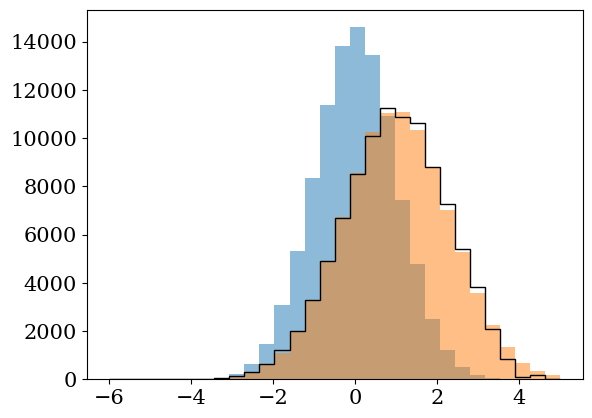

In [12]:
bins = np.linspace(-6,5,31)
plt.hist(X0_val, bins = bins, alpha = 0.5)
plt.hist(X0_val, bins = bins, weights=weights, histtype='step', color='k')
plt.hist(X1_val, bins = bins, alpha = 0.5)
plt.show()

The reweighted $\mu=0$ dataset matches the $\mu=1$!

# Reweighting $\mathcal{N}(0, 1)$ to $\mathcal{N}(\mu, 1)$ with one model for any $\mu$

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [9]:
n_data_points = 10**5
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

We then sample from normal distributions with this $\mu$ value

In [10]:
X0 = [(np.random.normal(0, 1), mu) for mu in mu_values] # Note the zero in normal(0, 1) 
X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [11]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [12]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [13]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 10000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Train on 160000 samples, validate on 40000 samples
Epoch 1/200
160000/160000 [==============================] - 0s 2us/sample - loss: 0.6467 - val_loss: 0.6095
Epoch 2/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5881 - val_loss: 0.5738
Epoch 3/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5705 - val_loss: 0.5703
Epoch 4/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5680 - val_loss: 0.5686
Epoch 5/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5667 - val_loss: 0.5679
Epoch 6/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5657 - val_loss: 0.5674
Epoch 7/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5650 - val_loss: 0.5666
Epoch 8/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5640 - val_loss: 0.5652
Epoch 9/200
160000/160000 [==============================] - 0s 1us/sample - 

## Validate DCTR for any $\mu$

In [14]:
mu1 = -1.5
assert mu1>=mu_min and mu1<=mu_max # choose mu1 in valid range

X0_val = np.random.normal(0, 1, n_data_points)
X1_val = np.random.normal(mu1, 1, n_data_points)

In [15]:
X_input = np.array([(x, mu1) for x in X0_val])

In [16]:
preds = dctr_model.predict(X_input)
weights = preds[:,1]/preds[:,0]

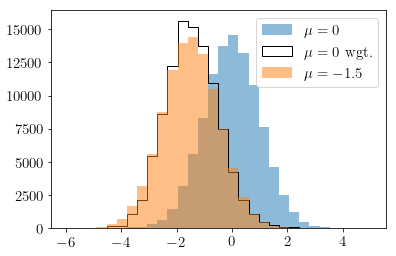

In [17]:
bins = np.linspace(-6,5,31)
plt.hist(X0_val, bins = bins, alpha = 0.5, label = r'$\mu=0$')
plt.hist(X0_val, bins = bins, label = r'$\mu=0$ wgt.', weights=weights, histtype='step', color='k')
plt.hist(X1_val, bins = bins, alpha = 0.5, label = r'$\mu={}$'.format(mu1))
plt.legend()
plt.show()

# Infer $\mu$ from unknown dataset ~ $\mathcal{N}(?, 1)$

## Build "mystery" dataset

In [18]:
mu_secret = 1.3
X_mystery = np.random.normal(mu_secret, 1, n_data_points)

In [19]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((np.array(X0)[:,0], X_mystery))
Y = np.concatenate((Y0, Y1))

## Build DCTR fit model

In [20]:
class AddParams2Input(Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, param):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.param = param
    
    def build(self, input_shape):
        # Convert input parameter to a weight and make it trainable
        self.param = self.add_weight(name='param', 
                                     shape=(1, 1),
                                     initializer=Constant(self.param),
                                     trainable=True)
            
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        return concatenate([input, self.param*tf.ones_like(input)], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+1)

In [21]:
mu_fit_init = 0

myinputs = Input(shape=(1,), name='input')
concat_input = AddParams2Input(mu_fit_init)(myinputs) 

for layer in dctr_model.layers:
    layer.trainable = False
        
# get the graph and the weights from the DCTR_model
output = dctr_model(inputs = concat_input)

dctr_fit_model = Model(inputs = myinputs, outputs = output)

dctr_fit_model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [22]:
dctr_fit_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
add_params2input (AddParams2 (None, 2)                 1         
_________________________________________________________________
model_1 (Model)              (None, 2)                 5352      
Total params: 5,353
Trainable params: 1
Non-trainable params: 5,352
_________________________________________________________________


In [23]:
def set_param(dctr_fit_model, param):
    weights = [np.array([[param]],   dtype=np.float32)]
    dctr_fit_model.layers[1].set_weights(weights)

In [24]:
def get_loss(X, Y, dctr_fit_model, MC_params, batch_size = 1000):
    set_param(dctr_fit_model, MC_params)
    return dctr_fit_model.evaluate(x=X, y = Y, batch_size=batch_size)

## Loss as a funciton of $\mu$

We can evaluate the loss as a funciton of $\mu$ to show that it has a minimum arond `mu_secret`

In [25]:
loss = np.array([(mu, get_loss(X, Y, dctr_fit_model, mu)) for mu in np.linspace(0,2, 31)])


200000/200000 [==============================] - 0s 1us/sample - loss: 0.5678


W1026 14:33:56.502396 4560479680 legend.py:1285] No handles with labels found to put in legend.


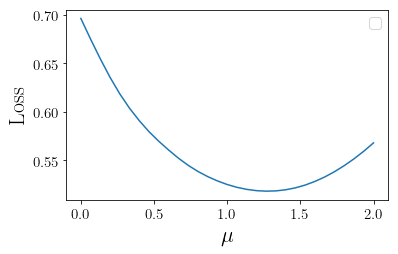

In [26]:
plt.plot(*loss.T)
plt.ylabel('Loss')
plt.xlabel(r'$\mu$')
plt.legend()
plt.tight_layout()
plt.show()

## Find mu_secret by gradient descent

In [27]:
set_param(dctr_fit_model, 0) # set mu back to default value

In [28]:
print_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: print("\n mu fit = ", 
                                               dctr_fit_model.get_weights()[0][0][0]))
fit_vals = [mu_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(dctr_fit_model.get_weights()[0][0][0]))

callbacks = [print_fit_value, append_fit_value]

In [29]:
dctr_fit_model.fit(X, Y, 
                   epochs=100, 
                   batch_size = 1000, 
                   callbacks=callbacks)

Train on 200000 samples
Epoch 1/100
167000/200000 [========================>.....] - ETA: 0s - loss: 0.6705
 mu fit =  0.19391052
200000/200000 [==============================] - 0s 2us/sample - loss: 0.6657
Epoch 2/100
171000/200000 [========================>.....] - ETA: 0s - loss: 0.6186
 mu fit =  0.3586035
200000/200000 [==============================] - 0s 1us/sample - loss: 0.6160
Epoch 3/100
171000/200000 [========================>.....] - ETA: 0s - loss: 0.5874
 mu fit =  0.497295
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5858
Epoch 4/100
162000/200000 [=======================>......] - ETA: 0s - loss: 0.5678
 mu fit =  0.6216057
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5659
Epoch 5/100
166000/200000 [=======================>......] - ETA: 0s - loss: 0.5519
 mu fit =  0.74014795
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5504
Epoch 6/100
170000/200000 [========================>.....] -

Epoch 46/100
163000/200000 [=======================>......] - ETA: 0s - loss: 0.5188
 mu fit =  1.278457
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 47/100
197000/200000 [============================>.] - ETA: 0s - loss: 0.5179
 mu fit =  1.2759706
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 48/100
170000/200000 [========================>.....] - ETA: 0s - loss: 0.5181
 mu fit =  1.28265
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 49/100
172000/200000 [========================>.....] - ETA: 0s - loss: 0.5186
 mu fit =  1.2775632
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 50/100
169000/200000 [========================>.....] - ETA: 0s - loss: 0.5189
 mu fit =  1.2825955
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 51/100
167000/200000 [========================>.....] - ETA: 0s - loss: 0.518

Epoch 91/100
169000/200000 [========================>.....] - ETA: 0s - loss: 0.5180
 mu fit =  1.2732774
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 92/100
197000/200000 [============================>.] - ETA: 0s - loss: 0.5177
 mu fit =  1.2799301
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 93/100
166000/200000 [=======================>......] - ETA: 0s - loss: 0.5186
 mu fit =  1.2826161
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 94/100
198000/200000 [============================>.] - ETA: 0s - loss: 0.5178
 mu fit =  1.2813878
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 95/100
161000/200000 [=======================>......] - ETA: 0s - loss: 0.5182
 mu fit =  1.2785214
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5179
Epoch 96/100
186000/200000 [==========================>...] - ETA: 0s - loss: 0.

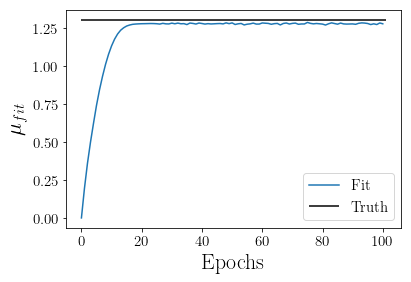

In [30]:
plt.plot(fit_vals, label='Fit')
plt.hlines(mu_secret, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\mu_{fit}$')
plt.legend()
plt.show()